Intention of this Notebook ist to test the performance of a "default" CNN network for regression, which will be the basis for further hypertuning. We will also see whether an inner three fold validation is necessary for each hypertuning step (if variance in results is low then not). //Turned out variance relatively low: 0.01134, even though 3 fold spit on subset of data.

The architecture is based on literature research, best practices and preveious experiments on a very similar problem setting.

In the end I also calculate the average prediction baseline *avg_pred*

## Set up notebook and environment: 

#### Connect to google drive: ####

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras #where?
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.image as mpimg
from keras.utils import plot_model
from sklearn import preprocessing
import gc
from sklearn.model_selection import KFold
import scipy.stats as st

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Specify location of all relevant data: (YOU HAVE TO INSERT YOUR FILE LOCATIONS) ####

In [0]:
print("Check correctnes of locations: ")
data_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Data/"
model_saves_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Default/"
data_filter_location = data_folder_location+"merck_and_co_dup_aa_concat_filter.npy"
X_location = data_folder_location+"X.npy"
y_location = data_folder_location+"y_growth_avg.npy"
print(os.path.isdir(data_folder_location))
print(os.path.isdir(model_saves_folder_location))
print(os.path.isfile(data_filter_location))
print(os.path.isfile(X_location))
print(os.path.isfile(y_location))

Check correctnes of locations: 
True
True
True
True
True


#### Function to easily retrieve cleaned data with split either from drive or cache, depending wheter data was already retrieved using this function ####

In [0]:
def retrieve_data(X_loc, y_loc, test_split=0.2, random_state=42):
  if not(os.path.isfile("X_train_H.npy")):
    #Load data from drive
    print("Loading data from drive...")
    X_load = np.load(X_loc)
    y_load = np.load(y_loc)
    filter_load = np.load(data_filter_location)
    
    #Apply pre filter
    X_load = X_load[filter_load]
    y_load = y_load[filter_load]
    
    #Remove all entries that have no temperature information #can happen, since for some organism specific temperature information is not available
    temp_label_filter = np.logical_not(np.isnan(y_load))
    X_load = X_load[temp_label_filter]
    y_load = y_load[temp_label_filter]
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=test_split, random_state=random_state) 
    
    #Cache data
    print("Caching data...")
    np.save('X_train_H.npy', X_train)   
    np.save('X_test_H.npy', X_test)   
    np.save('y_train_H.npy', y_train)   
    np.save('y_test_H.npy', y_test) 
    
    return X_train, X_test, y_train, y_test
  else:
    print("Loading data from cache...")
    return np.load('X_train_H.npy'), np.load('X_test_H.npy'), np.load('y_train_H.npy'), np.load('y_test_H.npy') 

In [0]:
X_train, X_test, y_train, y_test = retrieve_data(X_location,y_location)
gc.collect()

Loading data from drive...
Caching data...


19

## Supplementary functions

In [0]:
def train_on_TPU_regression(model,model_save_loc, X_train, y_train, X_test, y_test, batch_size=1024, epochs=25, save_best_only=True, period=1, train_patience=5, mse=True):
  print("Batch size: {} (this corresponds to {} on GPUs)".format(batch_size,batch_size//8))
  print("Epochs: ", epochs)
  print("Patience: ", train_patience)
  print("Period: ", period)
  print("Save best only: ",save_best_only)
  print("Model save location: ",model_save_loc)
  print("\n")
  
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()

  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")

  #Compile the model
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), ###tf.estimator.clip_gradients_by_norm(tf.train.AdamOptimizer(), clip_norm=1.0), #this shoudl work?!? #tf.contrib.tpu.CrossShardOptimizer(tf.train.AdamOptimizer(), reduction=tf.losses.Reduction.SUM),
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), ###tf.keras.optimizers.Adam(clipnorm=1.0)
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae','mse']
    )
  
  #Configure how to save model and early stopping
  callbacks_list = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath=model_save_loc,
          save_weights_only=True,
          monitor='val_loss', 
          save_best_only=save_best_only,
          mode='auto',
          period=period),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                       patience=train_patience, #more than 3 doesnt help (except when using generator), since the TPU runs out ouf memory for some reason???
                                       mode='auto')
  ]
  
  history = tpu_model.fit(X_train,
                          y_train,
                          validation_data=(X_test,y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=callbacks_list,
                          verbose=1)

  return tpu_model, history

In [0]:
def calc_reg_pred(model, weight_loc, X_test, y_test, batch_size=1024, mse=True, scaler=None):
  print("TPU worker setup:")
  #Identify TPU worker
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  
  #Useful to avoid clutter from old models / layers.
  tf.keras.backend.clear_session()
  
  #Convert model to TPU model
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  print("\n")
  
  #Compile the model #doesnt really matter which loss function here
  if mse:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(), 
      loss=tf.keras.losses.mean_squared_error,
      metrics=['mse']
    )
  else:
    tpu_model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=tf.keras.losses.mean_absolute_error,
      metrics=['mae']
    )
  
  tpu_model.load_weights(weight_loc)
  
  print("Calculating predictions:")
  y_pred = tpu_model.predict(X_test, batch_size=1024, verbose=1)

  if not(scaler is None):
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
  rmse_err = np.sqrt(mean_squared_error(y_test, y_pred)) 
  mae_err = mean_absolute_error(y_test, y_pred)
  
  return y_pred, rmse_err, mae_err

In [0]:
def plt_model(model,figure_size=(25,25)):
  plt.figure(figsize=figure_size)
  plot_model(model, to_file='model.png')
  plt.imshow(mpimg.imread('model.png'))
  plt.show()

#### Special Case Default Regressor training

In [0]:
kf = KFold(n_splits=3, random_state=42375, shuffle=True)

In [0]:
k_splits = []
for train_index, test_index in kf.split(X_train):
  k_splits.append((train_index, test_index))

In [0]:
train_index_01, test_index_01 = k_splits[0]
train_index_02, test_index_02 = k_splits[1]
train_index_03, test_index_03 = k_splits[2]

In [0]:
train_index_01[:10]

array([ 0,  1,  2,  4,  5,  6,  9, 10, 11, 13])

## Define Models ###


In [0]:
SEQUENCE_LEN = 650
CLASSES = 21 #now that sequences with non cannonical AAs removed there are 20 left and "0" encoding "None"

#### default model split 01

In [0]:
del X_train_inner
del X_test_inner
del y_train_inner
del y_test_inner
gc.collect()

In [0]:
X_train_inner, X_test_inner = X_train[train_index_01], X_train[test_index_01]
y_train_inner, y_test_inner = y_train[train_index_01], y_train[test_index_01]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

#actually nonsensical, but in this case not a big problem, since its the tune set
standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099572, 650)
(4099572,)
(2049787, 650)
(2049787,)


In [0]:
2049787%8

3

In [0]:
#default model
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batc



```
WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 318, 128)          49280     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 318, 128)          512       
_________________________________________________________________
activation_2 (Activation)    (None, 318, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 104, 256)          98560     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 104, 256)          1024      
_________________________________________________________________
activation_3 (Activation)    (None, 104, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 102, 256)          196864    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 102, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 102, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 256)          196864    
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 100, 256)          1024      
_________________________________________________________________
activation_5 (Activation)    (None, 100, 256)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 669,993
Trainable params: 667,177
Non-trainable params: 2,816
```



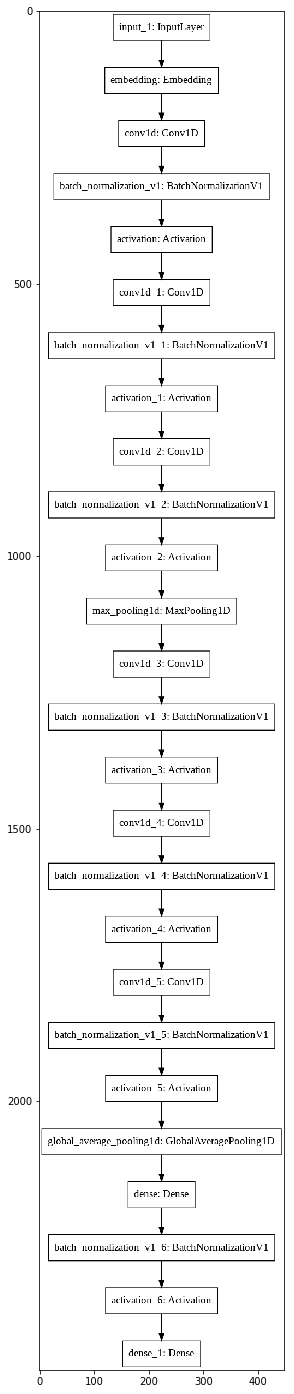

In [0]:
plt_model(model,figure_size=(25,25))

#### default model split 02

In [0]:
del X_train_inner
del X_test_inner
del y_train_inner
del y_test_inner
gc.collect()

732

In [0]:
X_train_inner, X_test_inner = X_train[train_index_02], X_train[test_index_02]
y_train_inner, y_test_inner = y_train[train_index_02], y_train[test_index_02]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

#actually nonsensical, but in this case not a big problem, since its the tune set
standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099573, 650)
(4099573,)
(2049786, 650)
(2049786,)


In [0]:
y_offset = len(y_test_scaled_inner)%8 #needed because of 8 tpu cores
y_offset

2

In [0]:
#default model
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
__________

#### default model split 03

In [0]:
del X_train_inner
del X_test_inner
del y_train_inner
del y_test_inner
gc.collect()

732

In [0]:
X_train_inner, X_test_inner = X_train[train_index_03], X_train[test_index_03]
y_train_inner, y_test_inner = y_train[train_index_03], y_train[test_index_03]

In [0]:
standard_scaler_inner = preprocessing.StandardScaler()
y_train_scaled_inner = standard_scaler_inner.fit_transform(y_train_inner.reshape(-1, 1)).reshape((len(y_train_inner))) #only fit on y_train to prevent information leakage

#actually nonsensical, but in this case not a big problem, since its the tune set
standard_scaler_test_inner = preprocessing.StandardScaler()
y_test_scaled_inner = standard_scaler_test_inner.fit_transform(y_test_inner.reshape(-1, 1)).reshape((len(y_test_inner))) #scale y_test seperately

In [0]:
print(X_train_inner.shape)
print(y_train_scaled_inner.shape)
print(X_test_inner.shape)
print(y_test_scaled_inner.shape)

(4099573, 650)
(4099573,)
(2049786, 650)
(2049786,)


In [0]:
y_offset = len(y_test_scaled_inner)%8 #needed because of 8 tpu cores
y_offset

2

In [0]:
#default model
inputs = tf.keras.layers.Input(shape=(SEQUENCE_LEN,))

x = tf.keras.layers.Embedding(CLASSES, 8, input_length=SEQUENCE_LEN)(inputs) 

x = tf.keras.layers.Conv1D(128, 7, 2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(128, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv1D(256, 3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding (Embedding)        (None, 650, 8)            168       
_________________________________________________________________
conv1d (Conv1D)              (None, 322, 128)          7296      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 322, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 322, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 128)          49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 320, 128)          512       
__________

## Train Models ###

#### Train default model split 01 ####

In [0]:
tpu_model, history = train_on_TPU_regression(model,model_saves_folder_location+"model_default_01.hdf5", X_train_inner, y_train_scaled_inner, X_test_inner[:-3], y_test_scaled_inner[:-3], train_patience=3, batch_size=1024)

#### Train default model split 02 ####

In [0]:
tpu_model, history = train_on_TPU_regression(model,model_saves_folder_location+"model_default_02.hdf5", X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], train_patience=3, batch_size=1024)

#### Train default model split 03 ####

In [0]:
tpu_model, history = train_on_TPU_regression(model,model_saves_folder_location+"model_default_03.hdf5", X_train_inner, y_train_scaled_inner, X_test_inner[:-y_offset], y_test_scaled_inner[:-y_offset], train_patience=3, batch_size=1024)

## Validate Models (default_t and default_h)

#### Validate default model split 01 ####

In [0]:
weights_location = model_saves_folder_location+"model_default_01.hdf5"

In [0]:
y_preds, rmse_err, mae_err = calc_reg_pred(model, weights_location, X_test_inner[:-3], y_test_inner[:-3], mse=True, scaler=standard_scaler_inner)

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.324944029780922
Root mean squared error:  9.055208634553333
```



In [0]:
print(X_test.shape)
offset_ = X_test.shape[0]%8
print("Offset: ",offset_)

(1537340, 650)
Offset:  4


In [0]:
y_preds, rmse_err, mae_err = calc_reg_pred(model, weights_location, X_test[:-offset_], y_test[:-offset_], mse=True, scaler=standard_scaler_inner)

TPU worker setup:

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.72.27.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6508952975008851049)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13137236254978697133)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17791949335288202495)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/t

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.3158892971053
Root mean squared error:  9.037419358831118
```



#### Validate default model split 02

In [0]:
weights_location = model_saves_folder_location+"model_default_02.hdf5"

In [0]:
y_preds, rmse_err, mae_err = calc_reg_pred(model, weights_location, X_test_inner[:-y_offset], y_test_inner[:-y_offset], mse=True, scaler=standard_scaler_inner)

TPU worker setup:

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.78.222.186:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14620600815996213837)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3387026562383448419)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6704080392187296075)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.240022255288514
Root mean squared error:  8.938713315589355
```



In [0]:
print(X_test.shape)
offset_ = X_test.shape[0]%8
print("Offset: ",offset_)

(1537340, 650)
Offset:  4


In [0]:
y_preds, rmse_err, mae_err = calc_reg_pred(model, weights_location, X_test[:-offset_], y_test[:-offset_], mse=True, scaler=standard_scaler_inner)

TPU worker setup:
INFO:tensorflow:Querying Tensorflow master (grpc://10.72.27.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6508952975008851049)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13137236254978697133)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17791949335288202495)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9972970149034546461)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8145135199108533797)
INFO:tensorflow:*** Available Device: _

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.228515505481873
Root mean squared error:  8.915510244922071
```



#### Validate default model split 03

In [0]:
weights_location = model_saves_folder_location+"model_default_03.hdf5"

In [0]:
y_preds, rmse_err, mae_err = calc_reg_pred(model, weights_location, X_test_inner[:-y_offset], y_test_inner[:-y_offset], mse=True, scaler=standard_scaler_inner)

TPU worker setup:
INFO:tensorflow:Querying Tensorflow master (grpc://10.78.222.186:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14620600815996213837)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3387026562383448419)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6704080392187296075)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10277753554312784944)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2508717580539106622)
INFO:tensorflow:*** Available Device:

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.1906517648754065
Root mean squared error:  8.794794928462332
```



In [0]:
print(X_test.shape)
offset_ = X_test.shape[0]%8
print("Offset: ",offset_)

(1537340, 650)
Offset:  4


In [0]:
y_preds, rmse_err, mae_err = calc_reg_pred(model, weights_location, X_test[:-offset_], y_test[:-offset_], mse=True, scaler=standard_scaler_inner)

TPU worker setup:
INFO:tensorflow:Querying Tensorflow master (grpc://10.72.27.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6508952975008851049)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13137236254978697133)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17791949335288202495)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9972970149034546461)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8145135199108533797)
INFO:tensorflow:*** Available Device: _

In [0]:
print("Mean absolute error: ", mae_err)
print("Root mean squared error: ", rmse_err)



```
Mean absolute error:  6.177662537219578
Root mean squared error:  8.782162360775716
```



## Results default_t and default_h)

In [0]:
#aggregate results in one table
columns = ["MAE_t","RMSE_t","MAE_h","RMSE_h"]
index = ["split_01","split_02","split_03"]
values = [[6.324944029780922,9.055208634553333,6.3158892971053,9.037419358831118],
         [6.240022255288514,8.938713315589355,6.228515505481873,8.915510244922071],
         [6.1906517648754065,8.794794928462332,6.177662537219578,8.782162360775716]]
results = pd.DataFrame(values, columns=columns, index=index)

In [0]:
results.head()

,MAE_t,RMSE_t,MAE_h,RMSE_h
split_01,6.324944,9.055209,6.315889,9.037419
split_02,6.240022,8.938713,6.228516,8.915510
split_03,6.190652,8.794795,6.177663,8.782162


In [0]:
results.describe()

,MAE_t,RMSE_t,MAE_h,RMSE_h
count,3.000000,3.000000,3.000000,3.000000
mean,6.251873,8.929572,6.240689,8.911697
std,0.067926,0.130447,0.069913,0.127671
min,6.190652,8.794795,6.177663,8.782162
25%,6.215337,8.866754,6.203089,8.848836
50%,6.240022,8.938713,6.228516,8.915510
75%,6.282483,8.996961,6.272202,8.976465
max,6.324944,9.055209,6.315889,9.037419


In [0]:
results.to_csv(model_saves_folder_location+"default_cnn_results.csv")

In [0]:
results.describe().to_csv(model_saves_folder_location+"default_cnn_results_described.csv")

**Results for the "base" model:**

* Train set performance: 6.251873 MAE, 8.929572 RMSE
* Holdout performance: 6.240689 MAE, 8.911697 RMSE

## Avg pred baseline: 

In [0]:
print("MAE Baseline: ",mean_absolute_error(np.ones((len(y_test)))*y_train.mean(), y_test)) 
print("RMSE Baseline: ",np.sqrt(mean_squared_error(np.ones((len(y_test)))*y_train.mean(), y_test)))

* MAE Baseline:  8.912778178475092
* RMSE Baseline:  12.695626430809082